# Valuación de opciones usando simulación

## 1. Motivación e introducción
En la clase pasada vimos el uso de la volatilidad (desviación estándar de los rendimientos) para valuar opciones. Asímismo, vimos como dado el valor de la opción podíamos calcular la volatilidad implícita por el método de valuación libre de riesgo.

Sin embargo, también vimos hace un par de clases que los rendimientos diarios no son generalmente un p.e. estacionario, así que suponerlos estacionarios como tal es caer en una falacia.

Importemos las librerías necesarias:

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

Con lo que hemos aprendido, deberíamos ser capaces de crear una función que nos devuelva un `DataFrame` de `pandas` con los precios de cierre ajustados de ciertas compañías en ciertas fechas:
- Escribir la función a continuación

In [13]:
def get_historical_closes(ticker, start_date, end_date=None):
    closes = web.DataReader(name=ticker, data_source='yahoo', start=start_date, end=end_date).sort_index('major_axis')
    return closes.loc['Adj Close',:]

- Obtener como ejemplo los precios de cierre de Apple del año pasado hasta la fecha. Graficar...

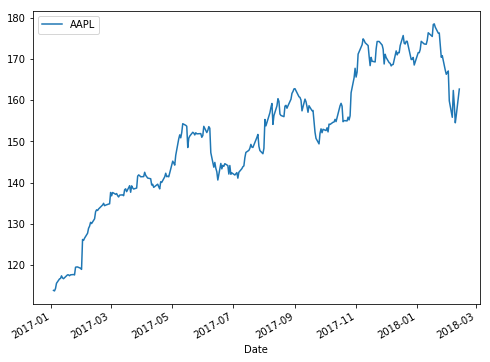

In [20]:
closes_aapl = get_historical_closes(['AAPL'], '2017-01-01')
closes_aapl.plot(figsize=(8,6));

- Escribir una función que pasándole el histórico de precios devuelva los rendimientos logarítmicos:

In [23]:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

- Graficar...

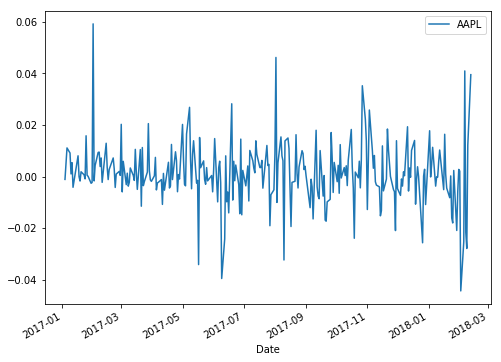

In [26]:
ret_aapl = calc_daily_ret(closes_aapl)
ret_aapl.plot(figsize=(8,6));

También, descargar datos de opciones de Apple:

In [29]:
opt_aapl = web.Options('AAPL', 'yahoo').get_all_data().reset_index()
opt_aapl

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
0,2.5,2018-02-16,put,...,2018-02-12 21:00:00,2018-01-20 04:44:39,"{'contractSymbol': 'AAPL180216P00002500', 'str..."
1,2.5,2018-04-20,call,...,2018-02-12 21:00:00,2017-11-28 16:24:01,"{'contractSymbol': 'AAPL180420C00002500', 'str..."
2,2.5,2018-04-20,put,...,2018-02-12 21:00:00,2017-09-23 03:55:28,"{'contractSymbol': 'AAPL180420P00002500', 'str..."
3,5.0,2018-04-20,call,...,2018-02-12 21:00:00,2018-01-23 19:15:39,"{'contractSymbol': 'AAPL180420C00005000', 'str..."
4,7.5,2018-04-20,call,...,2018-02-12 21:00:00,2018-01-27 04:51:03,"{'contractSymbol': 'AAPL180420C00007500', 'str..."
...,...,...,...,...,...,...,...
841,305.0,2018-04-20,call,...,2018-02-12 21:00:00,2018-02-12 15:47:41,"{'contractSymbol': 'AAPL180420C00305000', 'str..."
842,310.0,2018-04-20,call,...,2018-02-12 21:00:00,2018-02-12 15:45:31,"{'contractSymbol': 'AAPL180420C00310000', 'str..."
843,315.0,2018-04-20,put,...,2018-02-12 21:00:00,2018-02-12 17:56:03,"{'contractSymbol': 'AAPL180420P00315000', 'str..."
844,320.0,2018-04-20,call,...,2018-02-12 21:00:00,2018-02-07 14:32:34,"{'contractSymbol': 'AAPL180420C00320000', 'str..."


In [32]:
opt_aapl.loc[(opt_aapl.Expiry=='2018-06-15') & (opt_aapl.Type=='call') & (opt_aapl.Strike==180)]

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
570,180.0,2018-06-15,call,...,2018-02-12 21:00:00,2018-02-12 20:58:42,"{'contractSymbol': 'AAPL180615C00180000', 'str..."


In [34]:
opt_aapl.JSON[570]

{'ask': 3.45,
 'bid': 3.35,
 'change': 0.5300002,
 'contractSize': 'REGULAR',
 'contractSymbol': 'AAPL180615C00180000',
 'currency': 'USD',
 'expiration': 1529020800,
 'impliedVolatility': 0.2461012890625,
 'inTheMoney': False,
 'lastPrice': 3.4,
 'lastTradeDate': 1518469122,
 'openInterest': 23695,
 'percentChange': 18.466908,
 'strike': 180.0,
 'volume': 5032}

## 2. Valuación usando simulación: modelo normal para los rendimientos

Comenzaremos por suponer que los rendimientos son un p.e. estacionario que distribuyen $\mathcal{N}(\mu,\sigma)$.

- Hallar media y desviación estándar muestral de los rendimientos

In [37]:
mu = ret_aapl.mean().AAPL
sigma = ret_aapl.std().AAPL
mu, sigma

(0.001279960256838629, 0.011987126247996893)

No se toma la media sino la tasa libre de riesgo

In [41]:
r = 0.0162/360

- Simularemos el tiempo de contrato (días=123), 10 escenarios:
    - Generar fechas

In [38]:
ndays = 123
nscen = 10
dates = pd.date_range('2018-02-13', periods = ndays)
dates

DatetimeIndex(['2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
               '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20',
               '2018-02-21', '2018-02-22',
               ...
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09',
               '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13',
               '2018-06-14', '2018-06-15'],
              dtype='datetime64[ns]', length=123, freq='D')

- Generamos 10 escenarios de rendimientos simulados y guardamos en un dataframe

In [42]:
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r, index=dates)
sim_ret

,0,1,2,...,7,8,9
2018-02-13,0.015,-0.009,9.710e-03,...,-0.017,1.385e-02,0.009
2018-02-14,-0.011,-0.016,3.587e-03,...,-0.006,-4.806e-03,0.013
2018-02-15,-0.015,0.016,1.910e-02,...,0.027,-3.332e-04,-0.002
2018-02-16,0.002,-0.023,-1.394e-02,...,0.011,-1.913e-02,-0.003
2018-02-17,-0.006,0.016,1.756e-03,...,-0.002,-1.186e-02,0.001
...,...,...,...,...,...,...,...
2018-06-11,-0.007,-0.001,-5.306e-03,...,-0.022,1.246e-02,-0.006
2018-06-12,-0.003,0.002,-1.918e-02,...,0.006,7.655e-03,-0.008
2018-06-13,-0.004,0.024,-8.997e-04,...,0.008,3.262e-03,0.022
2018-06-14,0.008,0.007,1.383e-02,...,0.018,1.065e-02,-0.009


- Con los rendimientos simulados, calcular los escenarios de precios respectivos:

In [43]:
sim_closes = closes_aapl.iloc[-1].AAPL*np.exp(sim_ret.cumsum())
sim_closes

,0,1,2,...,7,8,9
2018-02-13,165.099,161.184,164.298,...,159.910,164.978,164.122
2018-02-14,163.236,158.613,164.888,...,158.986,164.187,166.199
2018-02-15,160.746,161.104,168.068,...,163.418,164.133,165.864
2018-02-16,160.988,157.473,165.743,...,165.275,161.024,165.385
2018-02-17,160.073,160.008,166.034,...,164.975,159.125,165.575
...,...,...,...,...,...,...,...
2018-06-11,181.191,149.056,191.437,...,145.477,152.524,148.976
2018-06-12,180.604,149.369,187.800,...,146.294,153.696,147.812
2018-06-13,179.955,153.068,187.632,...,147.439,154.198,151.092
2018-06-14,181.351,154.135,190.244,...,150.055,155.849,149.790


- Graficar:

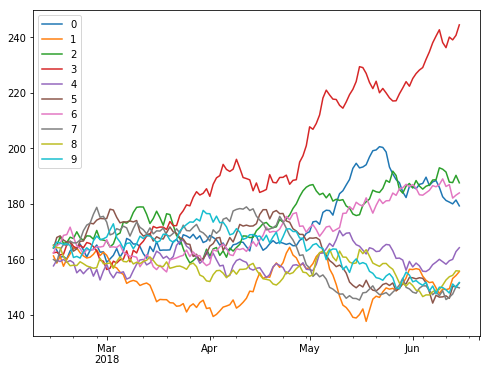

In [44]:
sim_closes.plot(figsize=(8,6));

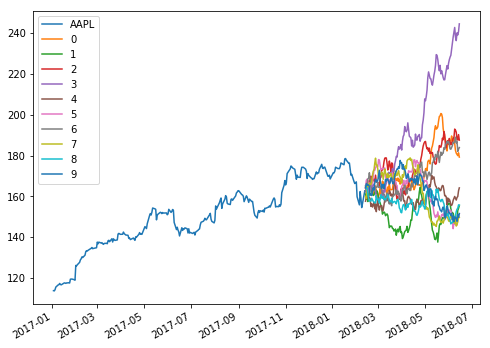

In [45]:
pd.concat([closes_aapl,sim_closes]).plot(figsize=(8,6));

In [71]:
K=180
ndays = 123
nscen = 100000
dates = pd.date_range('2018-02-13',periods=ndays)
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul = pd.concat([closes_aapl.T,strike.T,sim_closes.T]).T
#simul.plot(figsize=(8,6),legend=False);

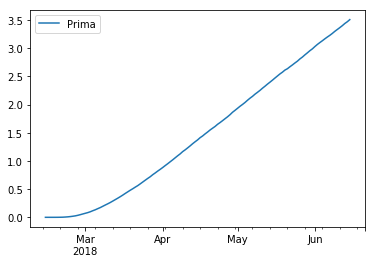

In [72]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()},index=dates)
call.plot();

In [73]:
call.iloc[-1]

Prima    3.505
Name: 2018-06-15 00:00:00, dtype: float64

In [74]:
sigma_est = sim_closes.iloc[-1].std()
(call.iloc[-1].Prima-2.576*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call.iloc[-1].Prima+2.576*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(3.3263359428275008, 3.6835157788404063)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>